# Zero-Noise Extrapolation

One of the most popular error mitigation techniques is Zero-Noise Extrapolation (ZNE). This was introduced at [] []. In ZNE,  an observable of interest $X$ and a quantum circuit $U$ are given. The idea is to run $U$ at increased noise levels $\{\lambda\}_{j=0}^{n}$ and measure the noisy expectation values for the observable $X$. These are noted as $\{\hat{\mu}\}_{j=0}^{n}$, where each noisy expectation value $\hat{\mu}_j$ is associated to each $\lambda_j$. With the resulting set of $\{\hat{\mu}\}_{j=0}^{n}$, one can extrapolate the zero-noise limit, or what it is the same, the noiseless expectation value of $X$. The main two components of ZNE are the noise scaling, encharged of scaling $U$ into the different $\lambda_j$, and the extrapolation method, that approximates the noiseless expectation value[1]. OpenQAOA makes use of Mitiq implementation of ZNE  [2].

In [1]:
from PIL import Image
img = Image.open('./zneworkflow.png')
#dind a way to resize without losing quality
img

FileNotFoundError: [Errno 2] No such file or directory: './zneworkflow.png'

$\textit{(image inspired by [])}$ 

## Noise scaling


For terms of simplicity in gate-model circuits implemented in most of the quantum programming languages, the technique used for noise scaling is unitary folding. This works by mapping gates $G \mapsto GG^{\dagger}G$. This leaves the ideal effect of the circuit invariant while increasing its depth. In a perfect quantum computer unitary folding will have zero effect on the results but in the current noisy hardware it will increase the noise. The local unitary folding can either local or global. In OpenQAOA, just local folding is supported. This is that the folding is applied to individual gates instead of applying to the whole circuit. These are some of the local unitary folding techniques that can be used from OpenQAOA :

* $\textit{fold\_gates\_at\_random}$
* $\textit{fold\_gates\_from\_right}$
* $\textit{fold\_gates\_from\_left}$

  

In the example below, we are scaling a simple circuit using the three techniques. When setting the `scale_factor` attribute in 3, we are scaling the circuit to have 3 times more gates than the original one. When the scale factor is 1, the circuit is unchanged.

In [8]:
import cirq
from mitiq import zne

# Get a circuit to fold
qreg = cirq.LineQubit.range(2)
circuit = cirq.Circuit(cirq.ops.H.on(qreg[0]), cirq.ops.CNOT.on(qreg[0], qreg[1]),cirq.ops.H.on(qreg[1]))
print("Original circuit:", circuit, sep="\n")

print("#######################################")

# Apply fold_gates_from_left
scaled_circuit = zne.scaling.fold_gates_from_left(circuit, scale_factor=3)
print("Fold gates from left:", scaled_circuit, sep="\n")

print("#######################################")

# Apply fold_gates_from_right
scaled_circuit = zne.scaling.fold_gates_from_right(circuit, scale_factor=3)
print("Fold gates from right:", scaled_circuit, sep="\n")

print("#######################################")

# Apply fold_gates_at_random
scaled_circuit = zne.scaling.fold_gates_at_random(circuit, scale_factor=3)
print("Fold gates at random:", scaled_circuit, sep="\n")

Original circuit:
0: ───H───@───────
          │
1: ───────X───H───
#######################################
Fold gates from left:
0: ───H───H───H───@───@───@───────────────
                  │   │   │
1: ───────────────X───X───X───H───H───H───
#######################################
Fold gates from right:
0: ───H───H───H───@───@───@───────────────
                  │   │   │
1: ───────────────X───X───X───H───H───H───
#######################################
Fold gates at random:
0: ───H───H───H───@───@───@───────────────
                  │   │   │
1: ───────────────X───X───X───H───H───H───


When the scale_factor is a real number, the difference between the folding techniques is easier to be seen.

In [9]:
# Apply fold_gates_from_left
scaled_circuit = zne.scaling.fold_gates_from_left(circuit, scale_factor=2.5)
print("Fold gates from left:", scaled_circuit, sep="\n")

print("#######################################")

# Apply fold_gates_from_right
scaled_circuit = zne.scaling.fold_gates_from_right(circuit, scale_factor=2.5)
print("Fold gates from right:", scaled_circuit, sep="\n")

print("#######################################")

# Apply fold_gates_at_random
scaled_circuit = zne.scaling.fold_gates_at_random(circuit, scale_factor=2.5)
print("Fold gates at random:", scaled_circuit, sep="\n")

Fold gates from left:
0: ───H───H───H───@───@───@───────
                  │   │   │
1: ───────────────X───X───X───H───
#######################################
Fold gates from right:
0: ───H───@───@───@───────────────
          │   │   │
1: ───────X───X───X───H───H───H───
#######################################
Fold gates at random:
0: ───H───@───@───@───────────────
          │   │   │
1: ───────X───X───X───H───H───H───


## Available extrapolation methods

* $\textit{Polynomial}$
* $\textit{Richardson}$
* $\textit{Exp}$
* $\textit{FakeNodes}$
* $\textit{Linear}$
* $\textit{AdaExp}$.

## How to use it with OpenQAOA?

For the matter of this tutorial, a ZNE mitigation will be done over a Maxcut instance.

### Begin by importing necessary modules

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

from openqaoa import QAOA  
from openqaoa.problems import MaximumCut
from openqaoa.backends import create_device
from openqaoa.utilities import ground_state_hamiltonian,plot_graph
from openqaoa.utilities import plot_graph

from qiskit import transpile
from qiskit_aer.noise import (NoiseModel, depolarizing_error)

### Step 1: Define a problem instance

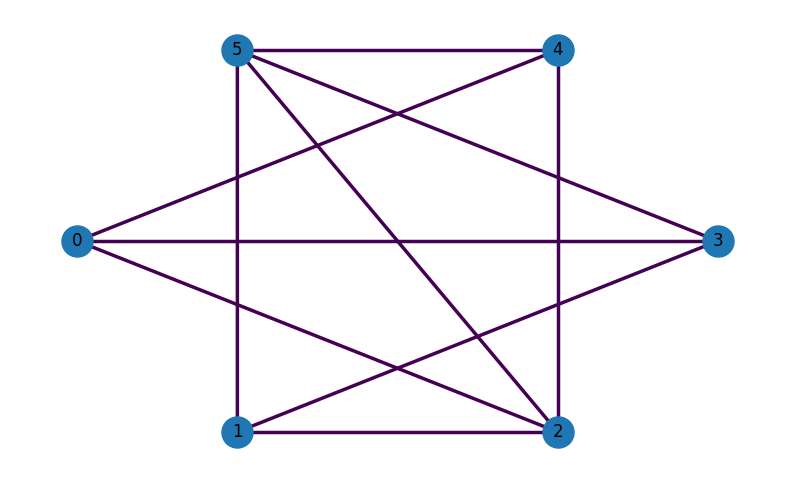

In [11]:
nodes = 6
edge_probability = 0.6
g = nx.generators.fast_gnp_random_graph(n=nodes, p=edge_probability, seed=42)

# import graph plotter from openqaoa
plot_graph(g)

# create the maximum cut instance and get its QUBO
maxcut = MaximumCut(g)
maxcut_qubo = maxcut.qubo

### Step 2: Extract the exact solution for a small enough problem

In [12]:
hamiltonian =  maxcut_qubo.hamiltonian

energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution/s: {configuration}")

Ground State energy: -6.0, Solution/s: ['001110', '110001']


### Step 3: Define a noise model

For a right integration with Mitiq, OpenQAOA makes a mandatory transpile of the QAOA parametric circuit to the basis gates $H$, $RX$ and $CX$. It is recommended to add noise only to that gates so as to have a succesful noise modelling.

In [13]:
# gates to add noise
one_qubit_gates = ['h','rx']
two_qubits_gates = ['cx']

def add_depolarizing_error(noise_model,probability1, probability2):
    noise_model = add_one_qubit_depolarizing_error(noise_model,probability1)
    noise_model = add_two_qubits_depolarizing_error(noise_model,probability2)
    return noise_model

def add_one_qubit_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 1)
    noise_model.add_all_qubit_quantum_error(error,one_qubit_gates)
    return noise_model

def add_two_qubits_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 2)
    noise_model.add_all_qubit_quantum_error(error, two_qubits_gates)
    return noise_model

#create the noise model
noise_model = add_depolarizing_error(NoiseModel(),0.0001989 ,0.007905)
noise_model

<NoiseModel on ['cx', 'h', 'rx']>

### Step 4: run a noiseless QAOA

In [14]:
# create, configure and run the QAOA
q1 = QAOA()

qiskit_device = create_device(location='local', name='qiskit.shot_simulator')

q1.set_device(qiskit_device)

q1.set_circuit_properties(p=4, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

q1.set_backend_properties(n_shots=5000,seed_simulator=1)

q1.set_classical_optimizer(method='Powell', maxiter=200, tol=0.01,maxfev=5000, optimization_progress=True, cost_progress=True, parameter_log=True)

q1.compile(maxcut_qubo)

q1.optimize()

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Cost history'}, xlabel='Number of function evaluations', ylabel='Cost'>)

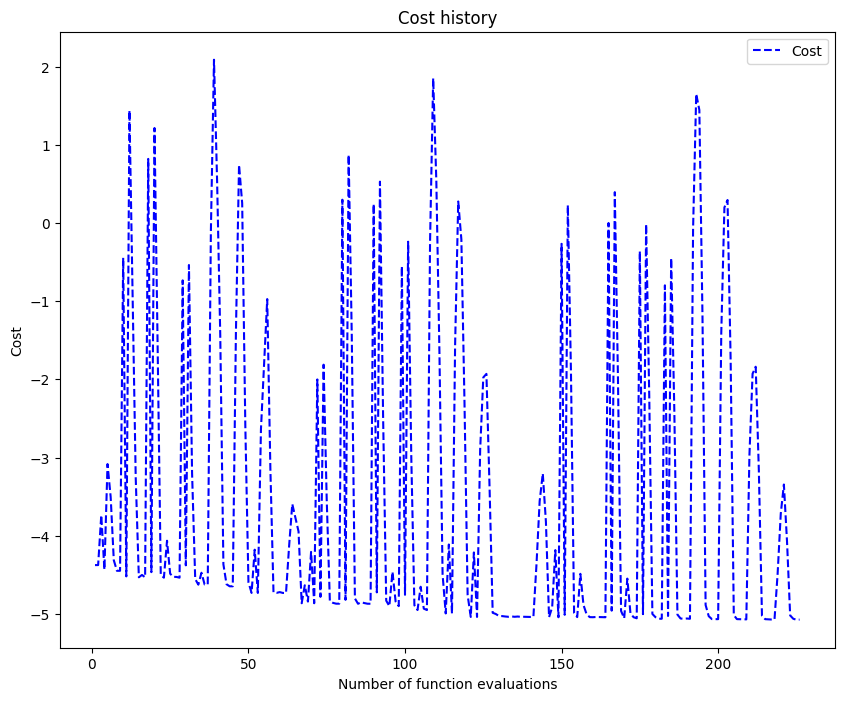

In [15]:
# access the results
opt_results1 = q1.result
opt_results1.plot_cost()

### Step 4: run a noisy QAOA

In [16]:
# create, configure and run the QAOA
q2 = QAOA()

qiskit_device = create_device(location='local', name='qiskit.shot_simulator')

q2.set_device(qiskit_device)

q2.set_circuit_properties(p=4, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

# here it is set the noise model
q2.set_backend_properties(n_shots=5000, noise_model=noise_model,seed_simulator=1)

q2.set_classical_optimizer(method='Powell', maxiter=200, tol=0.01,maxfev=5000, optimization_progress=True, cost_progress=True, parameter_log=True)

q2.compile(maxcut_qubo)

# it is necessary to transpile the parametric circuit with the same basis gates that has the noise model
q2.backend.parametric_circuit = transpile(q2.backend.parametric_circuit,basis_gates=["h","rx","cx"])

q2.optimize()

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Cost history'}, xlabel='Number of function evaluations', ylabel='Cost'>)

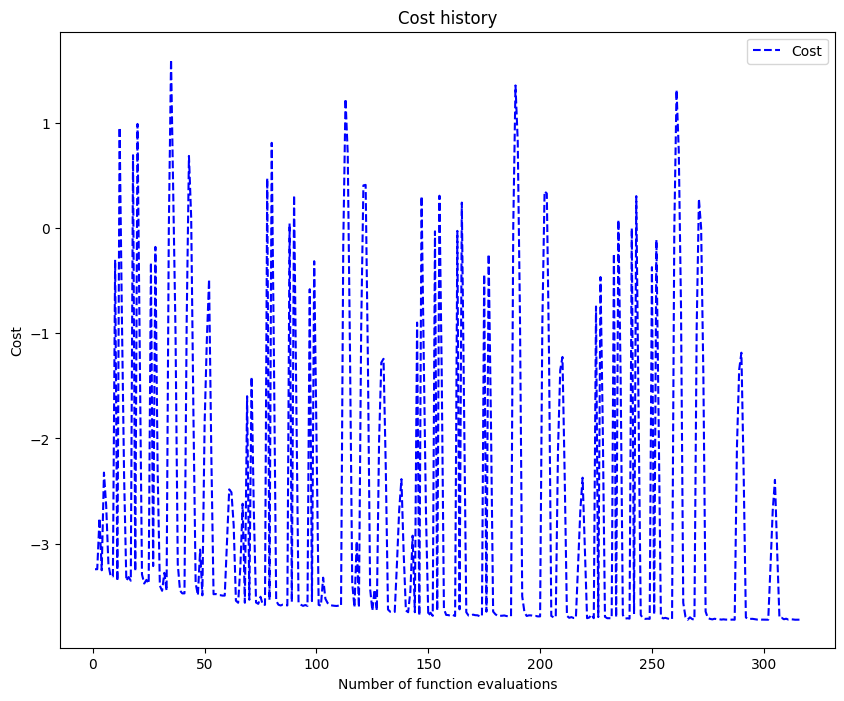

In [17]:
# access the results
opt_results2 = q2.result
opt_results2.plot_cost()

### Step 5: run a ZNE mitigated QAOA

Available options to set up the ZNE with `set_error_mitigation_properties`:

- **factory**: The name of the zero-noise extrapolation method. Supported values: "Richardson", "Linear", "Poly", "Exp", "PolyExp", "AdaExp", "FakeNodes".
- **scaling**: The name of the function for scaling the noise of a quantum circuit. Supported values: "fold_gates_at_random", "fold_gates_from_right", "fold_gates_from_left".
- **scale_factors**: List[int] Sequence of noise scale factors at which expectation values should be measured. For factory = "AdaExp", just the first element of the list will be considered.
- **order**: Extrapolation order (degree of the polynomial fit). It cannot exceed len(scale_factors) - 1. Only used for factory = "Poly" or "PolyExp".
- **steps**: The number of optimization steps. At least 3 are necessary. Only used for factory = "AdaExp".

In [18]:
# create, configure and run the QAOA
q3 = QAOA()

qiskit_device = create_device(location='local', name='qiskit.shot_simulator')

q3.set_device(qiskit_device)

q3.set_circuit_properties(p=4, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

# here is set the noise model
q3.set_backend_properties(n_shots=5000,seed_simulator=1,noise_model=noise_model)

q3.set_classical_optimizer(method='Powell', maxiter=100, tol=0.01,maxfev=5000, optimization_progress=True, cost_progress=True, parameter_log=True)

# here is set the ZNE
q3.set_error_mitigation_properties(error_mitigation_technique='mitiq_zne',factory = 'Richardson', scale_factors = [1,2,3])

q3.compile(maxcut_qubo)

q3.optimize()

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Cost history'}, xlabel='Number of function evaluations', ylabel='Cost'>)

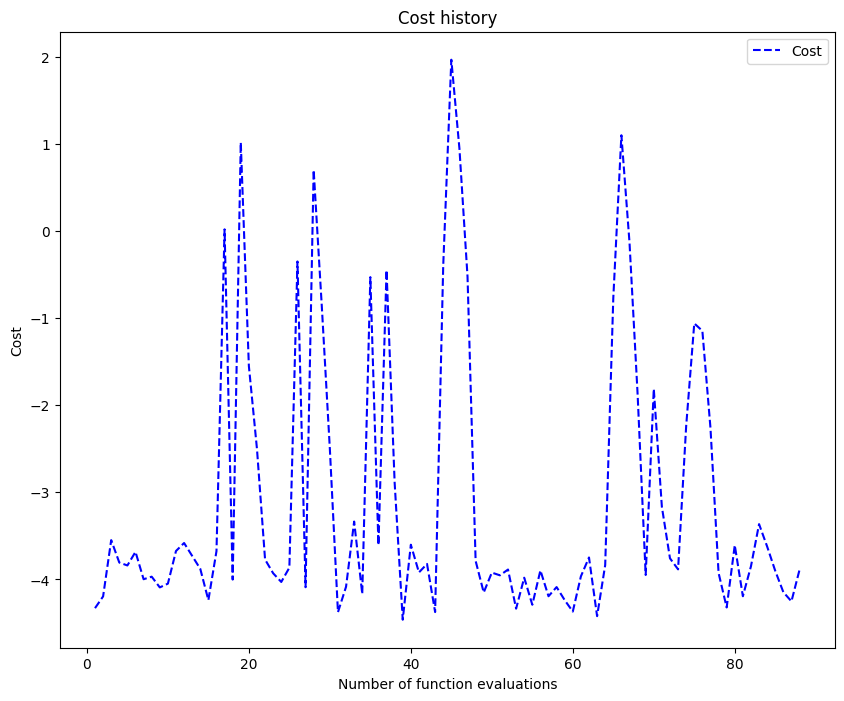

In [19]:
opt_results3 = q3.result
opt_results3.plot_cost()

In QAOA, the observable of interest $X$ is the cost, which is obtained from the bitstrings measurements of the quantum ansatz and used by the optimizer. For each of the $n$ optimizations of the QAOA workflow, an iteration of ZNE will be done before, resulting in $n$ extrapolated costs.

In $\texttt{backend.result\_factory\_objs}$ property, the $n$ extrapolations can be accesed.

Amount of extrapolations:  88
-----
extrapolated cost number  1


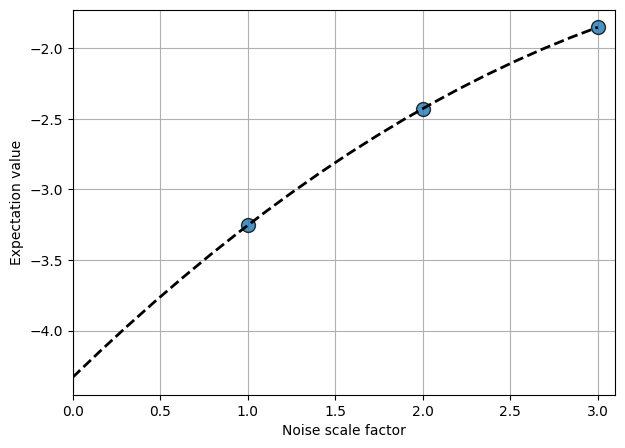

-----
...


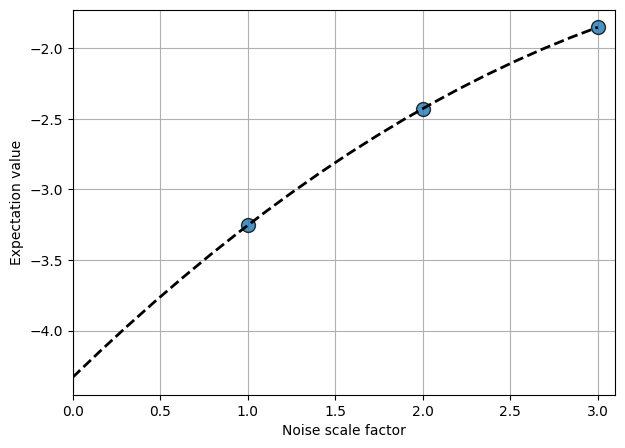

In [22]:
print('Amount of extrapolations: ',len(q3.backend.result_factory_objs))
extrapolated_costs = q3.backend.result_factory_objs[0:1]
for i,extrapolated_cost in enumerate(extrapolated_costs):
    print('-----')
    print('extrapolated cost number ',i+1)
    display(extrapolated_cost.plot_fit())
print('-----')
print('...')

### Step 6: Compare the cost plots

The resulting ZNE cost history is way more similar to the noiseless cost history. This works the same when comparing the lowest cost achieved. In some optimization problems, the optimal cost works like an useful approximate value for a particular property of the problem. In the case of Maxcut, the opposite of the resulting cost approximates the size of the maximum cut for the problem instance. That is, given a final optimal cost of $-5$, a good approximation for the maximum cut size is $5$. Because ZNE gets succeed when approximating the optimal cost, it can be used for the problems where this information could help in getting the optimal solution.

(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Cost history'}, xlabel='Number of function evaluations', ylabel='Cost'>)

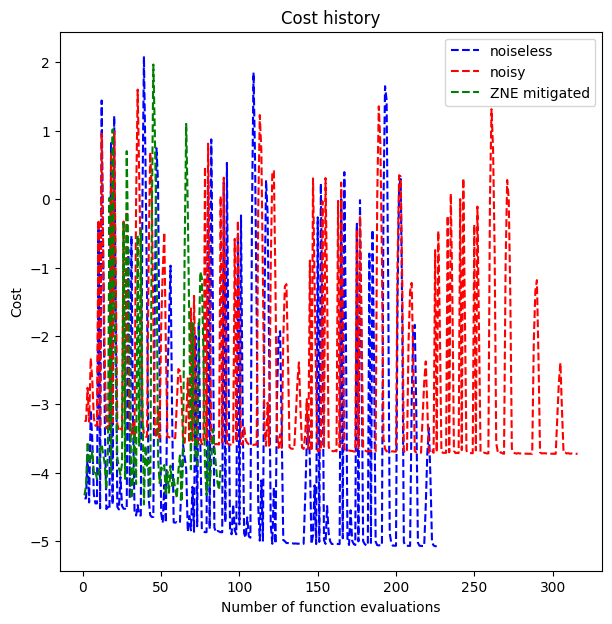

In [21]:
fig, ax = plt.subplots(figsize=(7,7))
opt_results1.plot_cost(figsize=(7,7),color='blue',label='noiseless',ax=ax)
opt_results2.plot_cost(figsize=(7,7),color='red',label='noisy',ax=ax)
opt_results3.plot_cost(figsize=(7,7),color='green',label='ZNE mitigated',ax=ax) 

## References


1.  $\href{https://quantum-journal.org/papers/q-2023-06-06-1034/}{\text{Bultrini, Daniel, et al. "Unifying and benchmarking state-of-the-art quantum error mitigation techniques." Quantum 7 (2023): 1034.}}$ 
2. $\href{https://quantum-journal.org/papers/q-2022-08-11-774/}{\text{LaRose, Ryan, et al. "Mitiq: A software package for error mitigation on noisy quantum computers." Quantum 6 (2022): 774.}}$
3. $\href{https://mitiq.readthedocs.io/en/stable/guide/zne.html}{\text{Mitiq: Zero Noise Extrapolation tutorial}}$